# Research Skills: Spatiotemporal Data Analysis
# Worksheet 5 - Forecasting with Spatial Data Analysis

Sharon Ong, Department of Cognitive Science and Artificial Intelligence – Tilburg University


### 0. Setup
Please specify in the next cell if you are working from Google Colab or from your own computer. Also indicate if you already have the necessary libraries installed.

In [2]:
COLAB = True
LIBRARIES_INSTALLED = False

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # Load the contents of the directory
    !ls
    # Change your working directory to the folder where you stored your files, e.g.
    %cd /content/drive/My Drive/Colab Notebooks/STDA

if not LIBRARIES_INSTALLED:
    !pip install geopandas
    !pip install libpysal
    !pip install esda
    !pip install spreg
    !pip install splot
    !pip install pykrige
    !pip install scikit-gstat
    !pip install contextily
    !pip install pointpats

from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import libpysal as ps
import esda as es
import spreg
import seaborn as sns
import contextily as ctx
import pointpats

Mounted at /content/drive
drive  sample_data
/content/drive/My Drive/Colab Notebooks/STDA
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 854.9/854.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.3/708.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 2.0 MB/s eta 0:00:00


# 1. Spatial Weights and Lag

## 1.1 Mapping the percentage of leave votes from Brexit in 2016

In 2016, the United Kingdom ran a referendum to decide whether to remain in the European Union or to leave the club, the so called “Brexit” vote. We will use the official data from the Electoral Commission at the local authority level on percentage of votes for the Remain and Leave campaigns. There are two distinct datasets we will combine:
*   Electoral Commission data on vote percentages at the local authority level in a csv file.
*   The shapes of the local authority districts in the UK in a GeoJSON file.  

The following code loads the two datasets and displays the first five rows.

In [4]:
# Load the vote results stored in a csv file into a pandas dataframe
vote = pd.read_csv(join('data', 'brexit_vote.csv'), index_col='Area_Code')
display(vote.head())
len(vote)

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E06000031,108,E12000006,East,Peterborough,120892,87474,87469,72.35,87469,87392,34176,53216,77,0,32,7,38,39.11,60.89,0.09
E06000032,109,E12000006,East,Luton,127612,84633,84636,66.31,84616,84481,36708,47773,135,0,85,0,50,43.45,56.55,0.16
E06000033,112,E12000006,East,Southend-on-Sea,128856,93948,93939,72.90,93939,93870,39348,54522,69,0,21,0,48,41.92,58.08,0.07
E06000034,113,E12000006,East,Thurrock,109897,79969,79954,72.75,79950,79916,22151,57765,34,0,8,3,23,27.72,72.28,0.04
E06000055,110,E12000006,East,Bedford,119530,86136,86136,72.06,86135,86066,41497,44569,69,0,26,1,42,48.22,51.78,0.08


382

In [5]:
# The shapes of the geographical units (local authority districts, in this case) are stored in a compressed GeoJSON file which we can load into a geopandas dataframe
lads = gpd.read_file(join('data', 'local_authority_districts.geojson')).set_index('lad16cd')
display(lads.head())
len(lads)

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


391

1. Create a new column called 'Pct_Leave' in the geodataframe and copy over the contents in column 'Pct_Leave' in the pandas dataframe.
2. Create a new geopandas dataframe with the following columns; **objectid**, **lad16nm**, **geometry** and **Pct_Leave**.
3. Drop all the rows with missing values from the output of 2.
4. Create a Choropleth Map of the local authority districts, with colors assigned by **Pct_Leave** (`columns='Pct_Leave'`). Use a quantiles scheme with 5 quantiles.  

<Axes: >

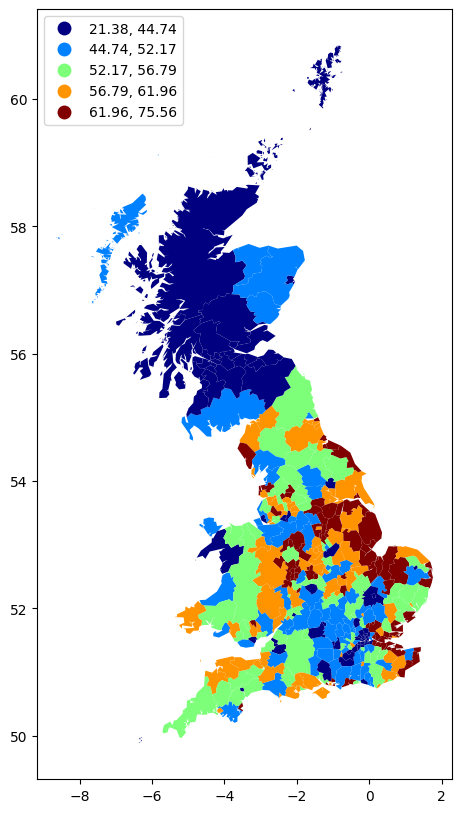

In [6]:
#
# Your code goes here
#

lads['Pct_Leave'] = vote['Pct_Leave']
lads = lads[['objectid', 'lad16nm', 'geometry', 'Pct_Leave']].dropna()

fig, ax = plt.subplots(figsize=(10, 10))
lads.plot(column='Pct_Leave',scheme='QUANTILES', k=5, cmap='jet',legend=True,ax=ax, legend_kwds={'loc': 'upper left'})


# 1.2 Spatial Weights
In spatial autocorrelation analysis, the spatial weights are used to formalize the notion of spatial similarity.

Spatial weights matrices are structured sets of numbers that formalize geographical relationships between the observations in a dataset. Essentially, a spatial weights matrix of a given geography is a $N$ by $N$ where $N$ is the total number of observations:
$$
W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0
\end{array} \right)
$$

where each cell $w_{i,j}$ contains a value that represents the degree of spatial contact or interaction between observations $i$ and $j$.
A neighbor of a given observation $i$ is another observation with which $i$ has some degree of connection.

The following code creates a spatial weight matrix using the 'queen' weighting scheme.

In [7]:
queen_weights = ps.weights.Queen.from_dataframe(lads)

## spatial weights
weight_matrix, ids = queen_weights.full()
print(f'{weight_matrix=}')

# Many common use cases of spatial weights require that the matrix is row-standardized.
# This is done simply in PySAL using the .transform attribute
queen_weights.transform = 'r'
weight_matrix, ids = queen_weights.full()
print(f'{weight_matrix=}')


<ipython-input-7-45f57970bf5f>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen_weights = ps.weights.Queen.from_dataframe(lads)


weight_matrix=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])
('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 331, ' is an island (no neighbors)')
('WARNING: ', 339, ' is an island (no neighbors)')
('WARNING: ', 342, ' is an island (no neighbors)')
('WARNING: ', 358, ' is an island (no neighbors)')
weight_matrix=array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.16666667,
        0.16666667],
       [0.        , 0.        , 0.     

/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: 46, 52, 331, 339, 342, 358.
  W.__init__(self, neighbors, ids=ids, **kw)


The following code finds the index in the dataframe for the Richmondshire district and its neighbours. Next, the code overlays the district in a map.

Index for Richmondshire district: [209]
Index of neighbouring district for spatial weights: [208, 7, 75, 76, 205, 206, 47]


<Axes: >

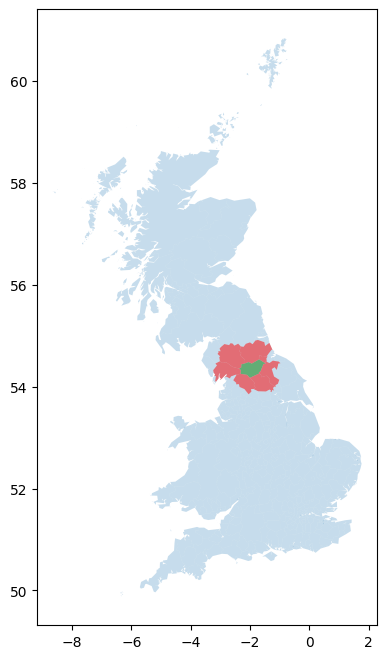

In [8]:
idx = np.flatnonzero(lads['lad16nm'] == 'Richmondshire')
print('Index for Richmondshire district:', idx)
neig_idxs = queen_weights.neighbors[idx[0]]
print('Index of neighbouring district for spatial weights:', neig_idxs)

# Plot all districts
ax = lads.plot(figsize = (8,8),alpha = 0.25, legend=True)

# Plot Richmond in green
richmond = lads[lads['lad16nm'] == 'Richmondshire']
richmond.plot(ax=ax,facecolor = 'g',alpha = 0.5)

# Plot neighbors of Richmond in red
lads.iloc[neig_idxs].plot(ax=ax, facecolor ='r', alpha = 0.5)

## 1.3 Attribute Similarity
So the spatial weight between provinces $i$ and $j$ indicates if the two districts are neighbors (i.e., geographically similar). What we also need is a measure of attribute similarity to pair up with this concept of spatial similarity. The spatial lag is a derived variable that accomplishes this for us. For province $i$ the spatial lag is defined as:

$$
ylag_i = \sum_jw_{i,j}y_i
$$

The following code computes the `Pct_Leave` lag and displays the `Pct_Leave` and its lag for two districts in a map.

In [9]:
lads['Pct_Leave_lag'] = ps.weights.spatial_lag.lag_spatial(queen_weights, lads['Pct_Leave'])

lads.loc[
    ['E08000012', 'S12000019'],
    ['Pct_Leave', 'Pct_Leave_lag']
]

,Pct_Leave,Pct_Leave_lag
lad16cd,,
E08000012,41.81,52.370000
S12000019,37.94,34.163333


Create a figure with two Choropleth maps of the local authority districts. One must have colors assigned by `Pct_Leave` and one must have colors assigned by `Pct_Leave_lag`. Use a quantiles scheme with 5 quantiles.

<Axes: >

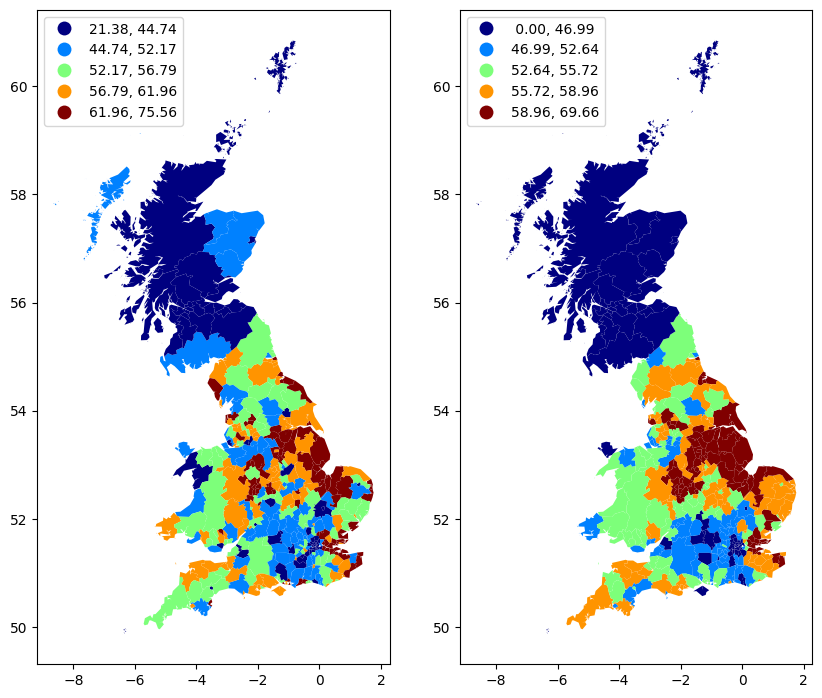

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 10))
lads.plot(column='Pct_Leave', scheme='QUANTILES', k=5, cmap='jet', legend=True, ax=axs[0], legend_kwds={'loc': 'upper left'})
lads.plot(column='Pct_Leave_lag', scheme='QUANTILES', k=5, cmap='jet', legend=True, ax=axs[1], legend_kwds={'loc': 'upper left'})

# 2.  Spatial Autocorrelation
Global spatial autocorrelation relates to the overall geographical pattern present in the data. Statistics designed to measure this trend thus characterize a map in terms of its degree of clustering and summarize it. This summary can be visual (with the Moran plot)  or numerical (Moran's I statistic of spatial autocorrelation).

## 2.1 Moran's plot
The moran plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag. In order to be able to interpret values as above or below the mean, and their quantities in terms of standard deviations, the variable of interest is usually standardized by subtracting its mean and dividing it by its standard deviation.

1. Make a scatter plot of the `Pct_Leave` of each district vs its  `Pct_Leave_Lag`.
2. Fit a straight line over the dataset (e.g. by adding a column of 1's and using `np.linalg.lstsq()`).
3. Plot the fitted line.
4. Plot a vertical line at the mean of the `Pct_Leave`.
5. Plot a horizontal line at the mean of the `Pct_Leave` spatial lag (`Pct_Leave_Lag`).

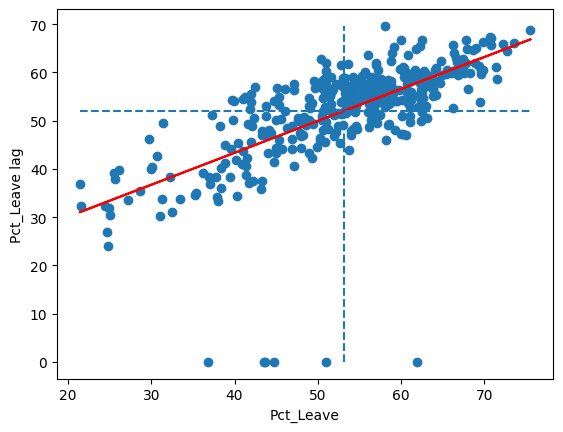

In [11]:
#
# Your code goes here
#

# 1.
plt.scatter(lads['Pct_Leave'], lads['Pct_Leave_lag'])
plt.xlabel('Pct_Leave')
plt.ylabel('Pct_Leave lag')

# 2.
X = np.vstack((np.ones(len(lads['Pct_Leave'])), lads['Pct_Leave'])).T
a, b = np.linalg.lstsq(X, lads['Pct_Leave_lag'], rcond=None)[0]

# 3.
plt.plot(lads['Pct_Leave'], a + b*lads['Pct_Leave'], 'r')

# 4.
plt.vlines(x=lads['Pct_Leave'].mean(), ymin=lads['Pct_Leave_lag'].min(), ymax=lads['Pct_Leave_lag'].max(), linestyle ='--')


# 5.
plt.hlines(y=lads['Pct_Leave_lag'].mean(), xmin=lads['Pct_Leave'].min(), xmax=lads['Pct_Leave'].max(), linestyle ='--')

plt.show()

The plot you will get shows a positive relationship between both variables. This is associated with the presence of positive spatial autocorrelation: similar values tend to be located close to each other. This means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values. If you had to summarize the main pattern of the data in terms of how clustered similar values are, the best way would be to say they are positively correlated and, hence, clustered over space.

## 2.2 Global Moran's $I$ Statistic
In PySAL, commonly-used analysis methods are very easy to access. For example, if we were interested in examining the global spatial dependence in Brexit voting, we could quickly compute a Moran's $I$ statistic:

In [12]:
# Compute Moran’s I Global Autocorrelation Statistic
mi = es.Moran(lads['Pct_Leave'], queen_weights)
print(mi.I, mi.p_sim)

0.623283711823588 0.001


/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.62', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.62)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

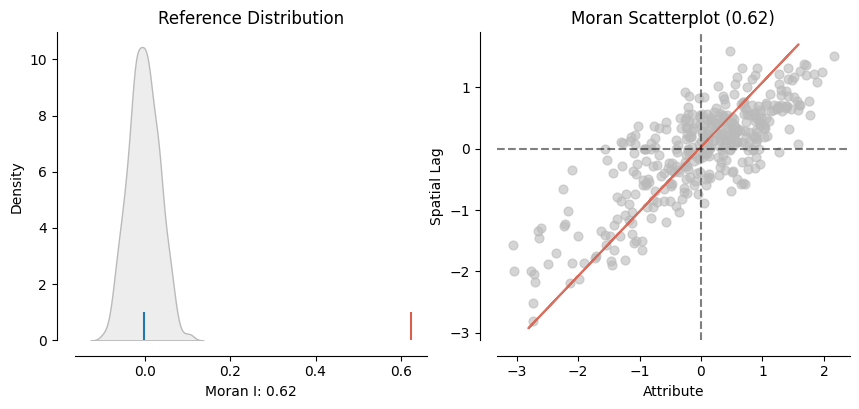

In [13]:
from splot.esda import plot_moran
plot_moran(mi)

# 3. Local Moran's $I$ Statistic
Moran's I is good tool to summarize a dataset into a single value that informs about its degree of clustering. However, it is not an appropriate measure to identify areas within the map where specific values are located. Moran's I can tell us values are clustered overall, but it will not show where the clusters are. For that purpose, we use a local measure of spatial autocorrelation. We also use a KNN weighting scheme as there are 'islands' in our shapefile.

/usr/local/lib/python3.10/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


<Axes: >

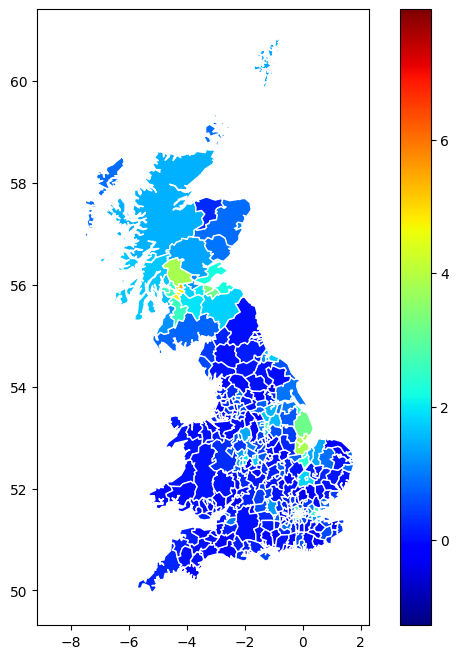

In [14]:
w = ps.weights.distance.KNN.from_dataframe(lads, k=2)

# Row-standardization
w.transform = 'R'
I_district_leave = es.Moran_Local(lads['Pct_Leave'], w)

# Display the local autocorrelation of each district using the qr lags
lads.assign(cl=I_district_leave.Is).plot(figsize=(8,8),column='cl',cmap='jet', edgecolor='w', legend=True)

We can distinguish the specific type of local spatial association reflected in the four quadrants of the Moran Scatterplot above. The units (which are significant) in first quadrant are hotspots, the third are coldspots,the second quadrant are doughnuts and the 4th quadrant are diamonds. The quadrant of each local autocorrelation unit can be found with the attribute `I_district_leave.q`

1. Find the significant local autocorrelation units.  `I_district_leave.p_sim < 0.05`.
2. Find the units in each quadrant which are significant (p value < 0.05).
3. Display the townships which are 'hotspots' and 'coldspots'

<Axes: >

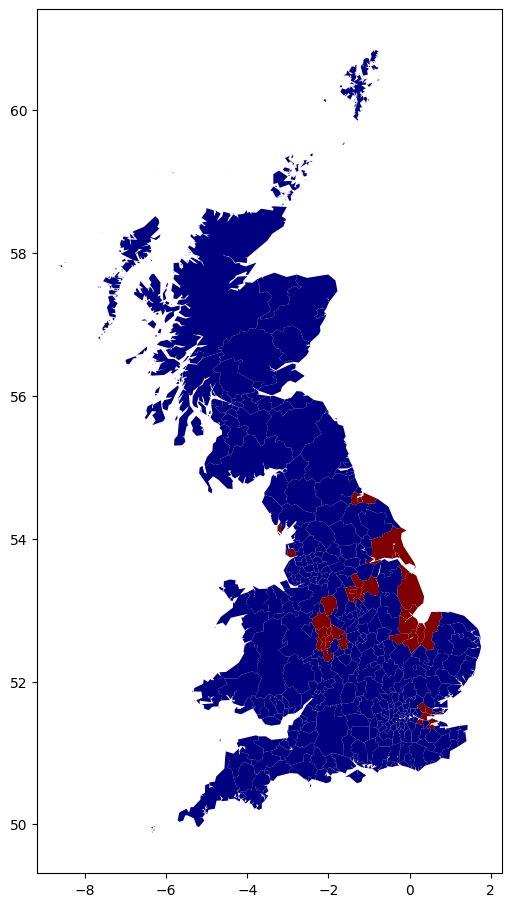

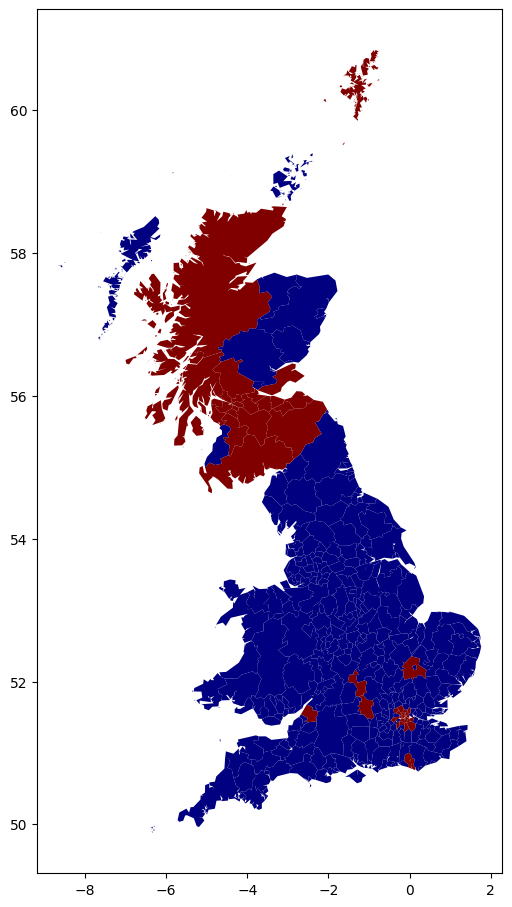

In [15]:
#
# Your code goes here
#

# find the significance of each local autocorrelation unit
sig = I_district_leave.p_sim < 0.05

# find the units in each quadart with p value < 0.05
hotspot = sig * I_district_leave.q==1
coldspot = sig * I_district_leave.q==3
doughnut = sig * I_district_leave.q==2
diamond = sig * I_district_leave.q==4


#
# Display the districts which are 'hotspots'
lads.plot(hotspot, figsize=(6,12), cmap = 'jet')
lads.plot(coldspot, figsize=(6,12), cmap = 'jet')


# 4. Spatial Autoregression

The following code loads a subset of the data from an airbnb dataset for Amsterdam. Then we extract a set of explanatory features of each listed property.

In [16]:
import pandas as pd
lst = pd.read_csv(join('data', 'airbnb_features_ams_red.csv'))
lst = lst[['longitude', 'latitude', 'price', 'bedrooms', 'beds', 'bathrooms', 'guests_included']]
lst.head()

,longitude,latitude,price,bedrooms,beds,bathrooms,guests_included
0,4.94142,52.36575,$59.00,1.0,2.0,1.5,1
1,4.89208,52.38673,$155.00,1.0,1.0,1.0,1
2,4.84838,52.35132,$219.00,3.0,3.0,1.0,4
3,4.88932,52.37537,$210.00,2.0,4.0,1.0,2
4,4.87447,52.36799,$140.00,2.0,2.0,1.0,2


The data has a few missing values which pandas assigns "NaN" numbers. Remove the rows with missing values.

In [17]:
lst.dropna(axis=0, how='any', inplace=True)

It is common practice to use the price in logarithms. The code below removes the dollar sign and thousands separator and takes the log of the price.

Create two boxplots in the same figure of the original and transformed prices.

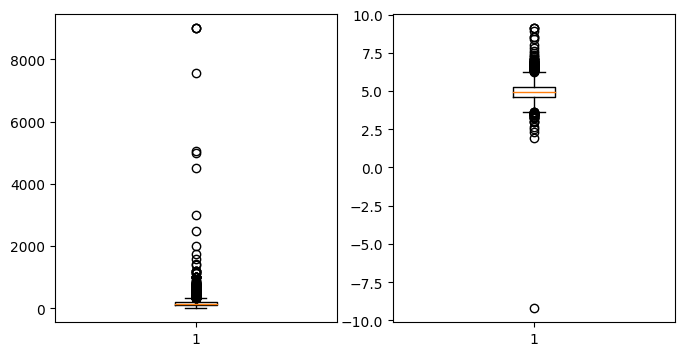

In [18]:
# Remove $ (escaped with \ because $ in regex has other meaning)
lst['price'] = lst['price'].replace('[\$,]', '', regex=True).astype(float)

# Add small amount because log is only defined for positive values
y = np.log(lst['price'] + 0.0001)

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
axs[0].boxplot(lst['price'])
axs[1].boxplot(y)
plt.show()

The following code fits the regression model.
\begin{equation}
\ln(price_i) = b + \mathbf{m} \mathbf{X}_i + \epsilon_i
\end{equation}
where $\epsilon_i$ is the error term, $\mathbf{m}$ and $b$  are the coefficients found from the data and $\mathbf{X}$ is the input data.

To run the model, we can use the spreg module in PySAL, which implements a standard ordinary least squares (OLS) routine, but is particularly well suited for regressions on spatial data. Also, although for the initial model we do not need it, the following code builds a spatial weights matrix that connects every observation to its 8 nearest neighbors. This will allow us to get extra diagnostics from the baseline model.

In [19]:
# Calculate W
w = ps.weights.KNN.from_array(lst.loc[lst.index, ['longitude', 'latitude']].values, k=10)
w.transform = 'r'
weight_matrix, ids = w.full()

# Fit OLS model
variable_names = ['bedrooms', 'beds', 'bathrooms', 'guests_included']
m1 = spreg.OLS(y.values, lst[variable_names].values, name_y='log_price', name_x=variable_names)
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6657
Mean dependent var  :      4.9311                Number of Variables   :           5
S.D. dependent var  :      0.5673                Degrees of Freedom    :        6652
R-squared           :      0.1966
Adjusted R-squared  :      0.1962
Sum squared residual:     1720.88                F-statistic           :    407.0660
Sigma-square        :       0.259                Prob(F-statistic)     :  3.471e-314
S.E. of regression  :       0.509                Log likelihood        :   -4942.967
Sigma-square ML     :       0.259                Akaike info criterion :    9895.933
S.E of regression ML:      0.5084                Schwarz criterion     :    9929.951

------------------------------------------------------------

We may want to add spatially lag variables that we think may affect the price of a house in a given location. For example, one could think that the number of beds present might affect the house price. If that is the case, then listed properties with more beds might be more expensive, which we already capture with the `beds` variable. Additionally, a property being surrounded by houses with more beds might mean that the house is in a more expensive neighborhood, which influences the price. To calculate the number of bed surrounding each property, we can build an alternative weights matrix based on beds.

In [20]:
lst['w_beds'] = ps.weights.lag_spatial(w, lst['beds'].values)
display(lst)

,longitude,latitude,price,bedrooms,beds,bathrooms,guests_included,w_beds
0,4.94142,52.36575,59.0,1.0,2.0,1.5,1,1.4
1,4.89208,52.38673,155.0,1.0,1.0,1.0,1,1.8
2,4.84838,52.35132,219.0,3.0,3.0,1.0,4,1.3
3,4.88932,52.37537,210.0,2.0,4.0,1.0,2,1.2
4,4.87447,52.36799,140.0,2.0,2.0,1.0,2,1.5
...,...,...,...,...,...,...,...,...
6668,4.92977,52.37185,95.0,1.0,1.0,1.0,1,1.6
6669,4.88524,52.38142,120.0,1.0,1.0,1.0,1,1.1
6670,4.91131,52.37328,189.0,1.0,1.0,1.0,2,2.8
6671,4.97859,52.35037,21.0,1.0,1.0,1.0,1,2.7


Fit a regression model with the variables from `m1` and the spatial lag of the number of beds.

In [21]:
variable_names_2 = variable_names + ['w_beds']
m2 = spreg.OLS(y.values, lst[variable_names_2].values, name_y='log_price', name_x=variable_names_2)
print(m2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6657
Mean dependent var  :      4.9311                Number of Variables   :           6
S.D. dependent var  :      0.5673                Degrees of Freedom    :        6651
R-squared           :      0.1999
Adjusted R-squared  :      0.1993
Sum squared residual:     1713.95                F-statistic           :    332.2994
Sigma-square        :       0.258                Prob(F-statistic)     :  1.134e-318
S.E. of regression  :       0.508                Log likelihood        :   -4929.534
Sigma-square ML     :       0.257                Akaike info criterion :    9871.069
S.E of regression ML:      0.5074                Schwarz criterion     :    9911.889

------------------------------------------------------------

You can also use the lag of the log_price target variable by applying spatial autoregression using the function GM_Lag.

In [22]:
m3 = spreg.GM_Lag(y.values, lst[variable_names].values, w=w, name_y='log_price', name_x=variable_names)
print(m3.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6657
Mean dependent var  :      4.9311                Number of Variables   :           6
S.D. dependent var  :      0.5673                Degrees of Freedom    :        6651
Pseudo R-squared    :      0.1443
Spatial Pseudo R-squared:  0.1999

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         5.33317         0.35841        14.88004         0.00000
            bedrooms         0.19082         0.01132        16.86126         0.00000
                beds         0.02890      

We can use the root mean squared error to compare the three regression models. Note: this evaluates the models on the training data, which does give a sense of how well the model fits the data, but not of how well a model can predict future data points.

In [23]:
def rmse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2) ** 0.5


rmses = pd.Series({'OLS': rmse(y.values, m1.predy.flatten()),
                  'OLS+W_beds': rmse(y.values, m2.predy.flatten()),
                  'Lag': rmse(y.values, m3.predy_e)})
rmses

OLS           0.508436
OLS+W_beds    0.507411
Lag           0.619966
dtype: float64

# Advanced Section

# 6. Spatial autocorrelation with different spatial weights
In addition to contiguity weights, distance weights and KNN weights can be used to compute spatial autocorrelation.
1. Using the KNN weighing scheme, compute the Global Moran's and Local Moran's $I$ Statistic for k = 3 and k = 10. Briefly comment on the result.
2. Using for loops, compute the Global Moran's $I$ Statistic for k = [3, 6, 12, 25, 50, 100]. Plot the results.
3. Using a binary distance weighing scheme, compute the Global Moran's and Local Moran's $I$ Statistic for a distance of 3 and 5.
4. Compute the Global Moran's $I$ Statistic for 5 to 6 different distances of your choice. Plot the results.
5. Repeat Question 4 with a distance based weighing scheme (set `binary= False`).

0.717480749554649 0.001
0.6274405019129154 0.001


<Axes: >

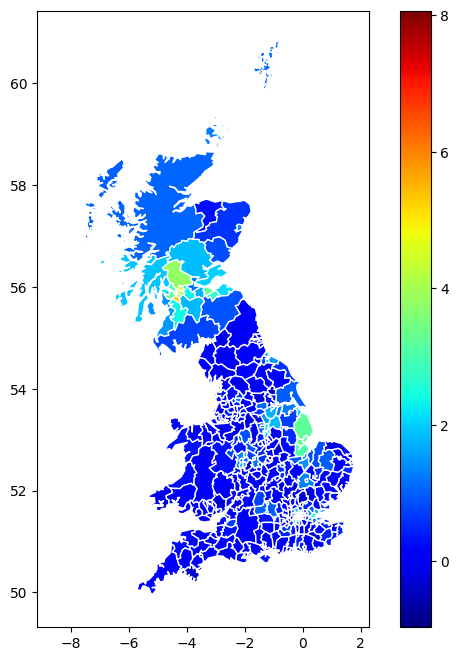

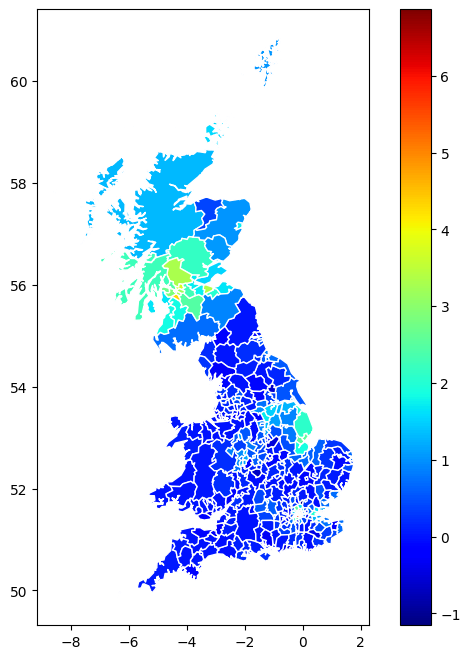

In [24]:
knn3 = ps.weights.KNN.from_dataframe(lads, k=3)
weight_matrix, ids = knn3.full()
knn3.transform = 'r'     #normalize the rows
mi = es.Moran(lads['Pct_Leave'].values, knn3)
print(mi.I, mi.p_sim)
I_district_leave = es.Moran_Local(lads['Pct_Leave'].values, knn3)

# Display the local autocorrelation of each district using the qr lags
lads.assign(cl=I_district_leave.Is).plot(figsize=(8, 8), column='cl', cmap='jet', edgecolor='w', legend=True)

knn10 = ps.weights.KNN.from_dataframe(lads, k=10)
knn10.transform = 'r'     #normalize the rows

mi = es.Moran(lads['Pct_Leave'].values, knn10)
print(mi.I, mi.p_sim)
I_district_leave = es.Moran_Local(lads['Pct_Leave'].values, knn10)

# Display the local autocorrelation of each district using the qr lags
lads.assign(cl=I_district_leave.Is).plot(figsize=(8, 8), column='cl', cmap='jet', edgecolor='w', legend=True)

#both K =3  and K =10 show there is positive autocorrelation. There is a higher global autocorrelation when k is smaller.
# The autocorrelation is more spread out when K is larger.

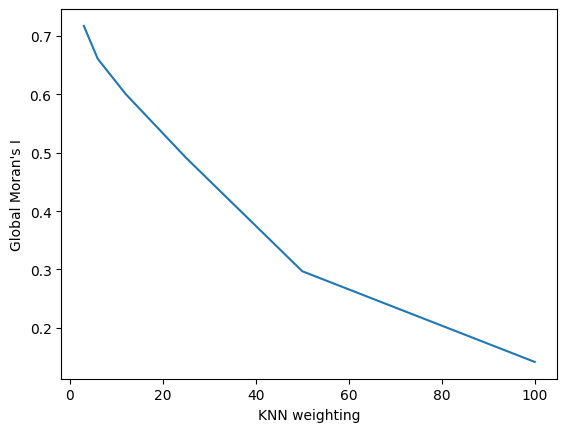

In [25]:
#2

global_is = []
ks = [3, 6, 12, 25, 50, 100]
for k in ks:
    knnV = ps.weights.KNN.from_dataframe(lads, k=k)
    knnV.transform = 'r'
    mi = es.Moran(lads['Pct_Leave'].values, knnV)
    global_is.append(mi.I)

plt.plot(ks,global_is)
plt.xlabel('KNN weighting')
plt.ylabel('Global Moran\'s I');

0.06642038766234032 0.001
-0.010334946964288685 0.001


<Axes: >

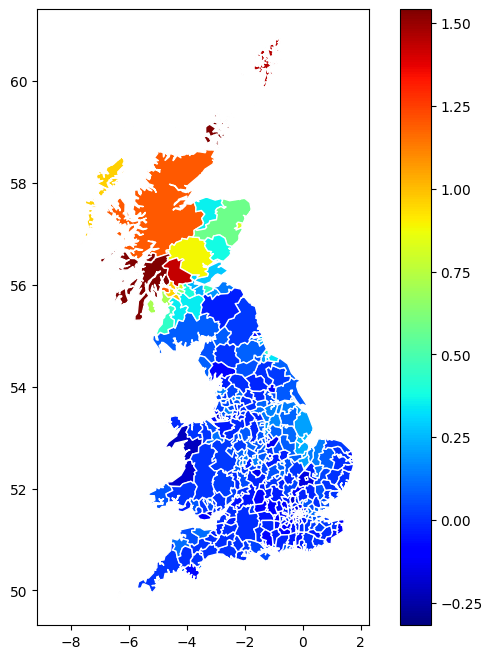

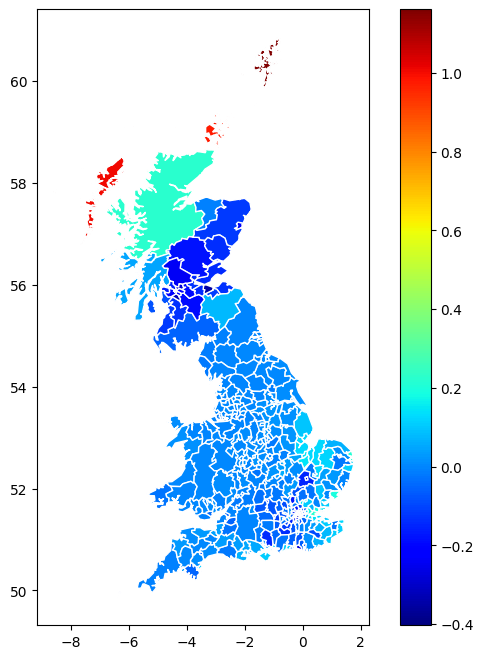

In [26]:
# 3
w_dist0p3 = ps.weights.DistanceBand.from_dataframe(lads, 3)
w_dist0p3.transform = 'r'

mi = es.Moran(lads['Pct_Leave'].values, w_dist0p3)
print(mi.I, mi.p_sim)
I_district_leave = es.Moran_Local(lads['Pct_Leave'].values, w_dist0p3)

# Display the local autocorrelation of each district using the qr lags
lads.assign(cl=I_district_leave.Is).plot(figsize=(8, 8), column='cl', cmap='jet', edgecolor='w', legend=True)

w_dist0p5 = ps.weights.DistanceBand.from_dataframe(lads, 5)
w_dist0p5.transform = 'r'

mi = es.Moran(lads['Pct_Leave'].values, w_dist0p5)
print(mi.I, mi.p_sim)
I_district_leave = es.Moran_Local(lads['Pct_Leave'].values, w_dist0p5)

# Display the local autocorrelation of each district using the qr lags
lads.assign(cl=I_district_leave.Is).plot(figsize=(8, 8), column='cl', cmap='jet', edgecolor='w', legend=True)

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_data.py:132: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


0.2674225260342173 0.001


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_data.py:132: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


0.19767941268425648 0.001


<Axes: >

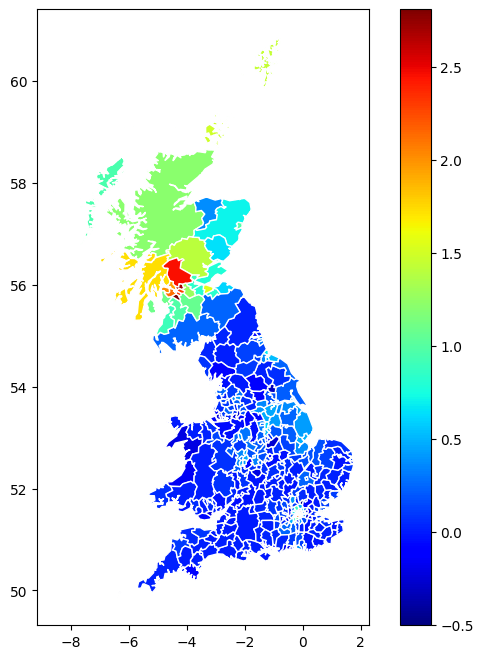

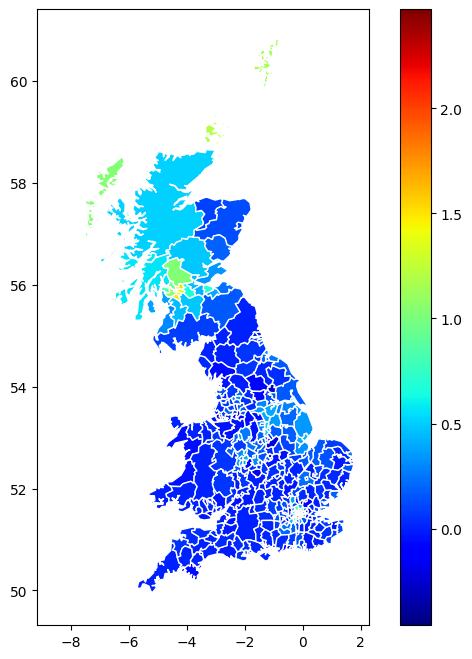

In [27]:
w_dist0p3 = ps.weights.DistanceBand.from_dataframe(lads, 3, binary=False)
w_dist0p3.transform = 'r'

mi = es.Moran(lads['Pct_Leave'].values, w_dist0p3)
print(mi.I, mi.p_sim)
I_district_leave = es.Moran_Local(lads['Pct_Leave'].values, w_dist0p3)

# Display the local autocorrelation of each district using the qr lags
lads.assign(cl=I_district_leave.Is).plot(figsize=(8, 8), column='cl', cmap='jet', edgecolor='w', legend=True)

w_dist0p5 = ps.weights.DistanceBand.from_dataframe(lads, 5, binary=False)
w_dist0p5.transform = 'r'

mi = es.Moran(lads['Pct_Leave'].values, w_dist0p5)
print(mi.I, mi.p_sim)
I_district_leave = es.Moran_Local(lads['Pct_Leave'].values, w_dist0p5)

# Display the local autocorrelation of each district using the qr lags
lads.assign(cl=I_district_leave.Is).plot(figsize=(8, 8), column='cl', cmap='jet', edgecolor='w', legend=True)